**Content**: [Olivier Bernard](https://www.creatis.insa-lyon.fr/~bernard/), [Thomas Grenier](https://www.creatis.insa-lyon.fr/~grenier/) from the [CREATIS](https://www.creatis.insa-lyon.fr/site7/en) Laboratory, France<br>


***

Hands-on: Echocardiographic image segmentation with deep learning (part 2)
===

# <span style="color:brown"> **Preamble**

The second part of this hands-on will allow you to study in depth the structure and performance of the popular deep learning U-Net architecture, in the context of echocardiographic image segmentation. You will still use the open access CAMUS dataset. In particular, you will use only a fraction of this dataset, *i.e.* apical four-chamber views (4CH) at End-Diastole (ED) and End-Systole (ES) for 500 patients.
    
# <span style="color:brown"> **Objectives**

* Study how to code a deep learning segmentation method with the tensorflow python library,
* Compare the performance of a U-Net model based on the choice of key parameters.
    
***

# <span style="color:brown"> **Reminder on the U-Net architecture**

U-Net is based on a two-stage convolutional network architecture. The first part, known as the encoder, is similar to conventional CNNs and extracts high-level information. The second part is the decoder, which uses information from the encoder and applies a set of convolutions and upsampling operations to gradually transform feature maps with the purpose of reconstructing segmentation maps at the resolution of the imput image. U-Net architecture also integrates skip connections between the encoder and decoder parts with the goal of retrieving details that were potentially lost during the downsampling while also stabilizing the learning procedure. An illustration of the network architecture is given below (please refer to Chapter 4 of the book for further explanation, in particular Figure 4.4).
    
<br>
        
<img src="figures/illustration_UNet_US.png" alt="UNet" style="width: 85%;"/>

<br>

The U-Net architecture can be defined through the following main parameters:
- the number of feature maps at the first level
- the number of levels
- the use of the batch normalizations at each level
- the type of activation functions
- the use of dropout operations
- the use of data augmentation

The performance of deep learning model also depends on the optimization conditions that were used during the learning process, the main ones being:
- the optimization algorithm (*ADAM* and *RMSprop* being among the most popular)
- the learning rate

### <span style="color:red"> Questions

- ### What were the main parameters of the U-Net architecture you used in the previous notebook ? (in terms of number of feature maps at the first level, number of levels, batch normalization, dropout)
- ### How many parameters does this network have ?

>TODO: Your answer here.

***

# <span style="color:brown"> **Before starting: system setting**
 
### <span style="color:red"> Instruction: </span> Run the cell below to download pre-trained models that you will use during this session.

In [15]:
# Let's download pre-trained AI models
#!rm -r trained_model
#!wget https://www.creatis.insa-lyon.fr/~bernard/jupyter/trained_model.zip
#!unzip -q trained_model.zip
#!rm trained_model.zip

***

# <span style="color:brown"> **Before starting: system setting**
 
### <span style="color:red"> Instruction: </span> Run the cell below to import all the packages that you will need during this session.

In [16]:
%pip install matplotlib
%pip install numpy==1.23.5
%pip install opencv-python
%pip install medpy==0.4.0
%pip install tqdm
%matplotlib inline
%pip install pandas

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import os
plt.rcParams["figure.figsize"] = (15,15)

print(f"numpy version : {np.__version__}")
%load_ext autoreload
%autoreload 2

numpy version : 1.23.5


In [3]:
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### <span style="color:red"> Instruction: </span> Run the cell below to import our own modules that you will need during this session.

In [2]:
# from keras_unet.losses import dice_loss
# from keras_unet.metrics import dice_coef, iou, iou_thresholded
from keras_unet.visualization import plot_overlay_segmentation

# Add our own python modules stored in the folders present at the root level of this project
if "../" in sys.path: 
    print(sys.path)
else: 
    sys.path.append("../")
    print(sys.path)

if "model" in locals(): 
    print("deleting model")
    del model    
    
# Select the CPU device to run on
num_CPU = 1
num_cores = 4
tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3" 

['c:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main', 'c:\\Users\\user\\anaconda3\\envs\\py310\\python310.zip', 'c:\\Users\\user\\anaconda3\\envs\\py310\\DLLs', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310', '', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\Pythonwin', '../']


***

# <span style="color:brown"> **1) Load and prepare dataset**
    
As for the previous part of the hands-on, you will use a the CAMUS dataset restricted to apical four-chamber views at End-Diastole and End-Systole time instants from 500 patients. This dataset was divided into three folds:

- ***dataset/segmentation/train*** representing 80% of the dataset. This subset will be used to train the network by updating its parameters to get the best results on the corresponding data.
- ***dataset/segmentation/valid*** representating 10% of the dataset. This subset will be used to select the network parameters which produce the best results on the training dataset.
- ***dataset/segmentation/test*** representing 10% of the dataset. This subset will be used to assess the scores that can reach the trained network on unseen data.    

## <span style="color:brown"> 1.1) Load data

In [3]:
from keras_unet.utils import load_CAMUS_dataset

# Parameters
IMG_SIZE = 256  # All the images will be resized to IMG_SIZE x IMG_SIZE to speed up the process. 

dataset_train_path = "dataset/segmentation/train/"
dataset_valid_path = "dataset/segmentation/valid/"
dataset_test_path = "dataset/segmentation/test/"

# Load data
[X_train, y_train] = load_CAMUS_dataset(dataset_train_path, IMG_SIZE)
[X_valid, y_valid] = load_CAMUS_dataset(dataset_valid_path, IMG_SIZE)
[X_test, y_test] = load_CAMUS_dataset(dataset_test_path, IMG_SIZE)


100%|██████████| 100/100 [00:00<00:00, 3580.96it/s]


In [4]:
# Display the matrix size and pixel type for the return variables 
print(" Dimensions of X_train : ", X_train.shape)
print(" Dimensions of y_train : ", y_train.shape)
print(" ")
print(" Dimensions of X_valid : ", X_valid.shape)
print(" Dimensions of y_valid : ", y_valid.shape)
print(" ")
print(" Dimensions of X_test : ", X_test.shape)
print(" Dimensions of y_test : ", y_test.shape)

 Dimensions of X_train :  (800, 256, 256, 1)
 Dimensions of y_train :  (800, 256, 256, 4)
 
 Dimensions of X_valid :  (100, 256, 256, 1)
 Dimensions of y_valid :  (100, 256, 256, 4)
 
 Dimensions of X_test :  (100, 256, 256, 1)
 Dimensions of y_test :  (100, 256, 256, 4)


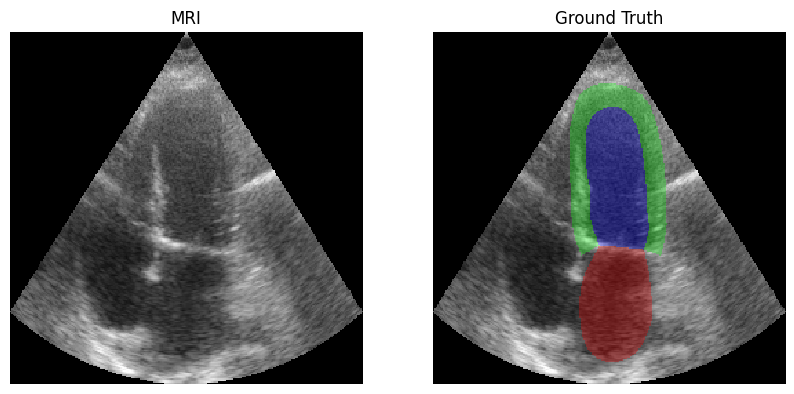

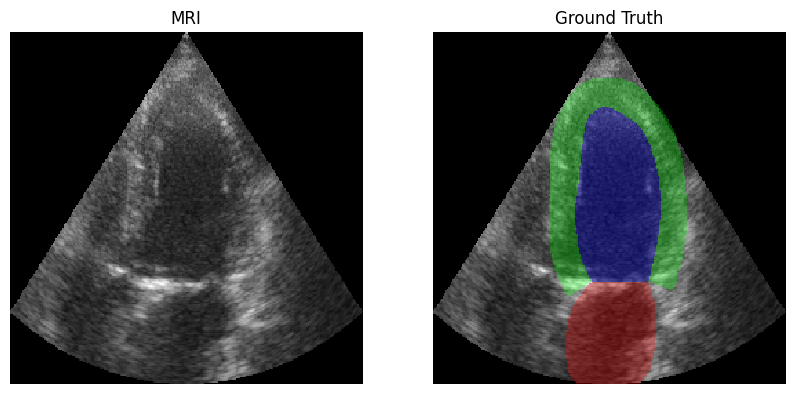

In [7]:
# Parameter to play with
dataset_type = 2    # select 0, 1 or 2 to see images from the train, valid or test dataset, respectively
nb_imgs = 2         # number of images that will be displayed

# Select random values
start_ind = (np.random.randint(0, X_test.shape[0]-nb_imgs, size=1))[0]
end_ind = start_ind+nb_imgs

# Display the random images with the corresponding reference mask
if dataset_type==0:
    plot_overlay_segmentation(X_train[start_ind:end_ind], y_train[start_ind:end_ind])
if dataset_type==1:
    plot_overlay_segmentation(X_valid[start_ind:end_ind], y_valid[start_ind:end_ind])
if dataset_type==2:
    plot_overlay_segmentation(X_test[start_ind:end_ind], y_test[start_ind:end_ind])

***

# <span style="color:brown"> **2) Prepare the U-Net architecture**
    
## <span style="color:brown"> 2.1) Define important parameters
    
### <span style="color:red"> Instruction: </span> Run the cell below to select the values of the main parameters that define a U-Net architecture.

In [8]:
# Network architecture related values 
NBFILTERS_L1_UNET = 32  # Number of feature maps for the first level
NBLAYERS_UNET = 4       # Number of levels
DROPOUT_RATE = 0.1      # Dropout action used at each level (value between 0.0 and 1.0, 0.0 meaning no dropout)
BATCHNORM_ON = True     # Use of batch normalisation after each convolutional layer (value = True or False)

# Training parameters
NBEPOCHS = 100          # Number of epochs
BATCH_SIZE = 16         # Number of samples in each batch (usually the value is a multiple of 2)
NBSTEPS_PER_EPOCH = 50  # Number of batches per epoch (1  to ...) (used for data augmentation)
NBPATIENCE_EPOCHS = 50  # Number of epoch after a minimum detection before stopping (early stop)

## <span style="color:brown"> 2.2) Prepare a generator for data augmentation
    
During the learning phase of a deep learning model, it is generally recommended to use a data augmentation strategy to improve the generalization capability of the algorithm. Data augmentation consists of applying some pre-defined transformation operations (*e.g.* rotation, translation or pixel intensity clipping, etc...) on the input data during the filling of the batches. By doing so, the algorithm will never see the exact same input images, which will force it to be less sensitive to the changes applied.

In [9]:
from keras_unet.utils import get_augmented

# Creation of a tensorflow generator object to manage data augmentation.
# The different data augmentation operations are defined as input parameter of the function
train_gen = get_augmented(
    X_train, y_train, batch_size=BATCH_SIZE,  
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=10,
        zoom_range=0.2,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='constant',
        cval = 0
    ))

### <span style="color:red"> Instruction: </span> Run the cell below to visualize the impact of the data augmentation strategy on the input images.

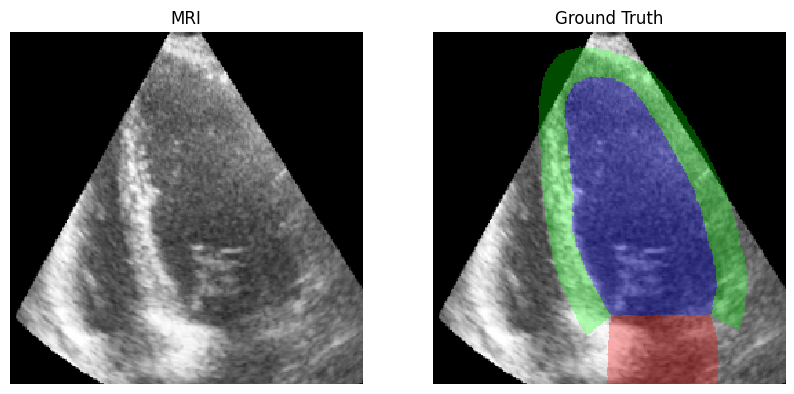

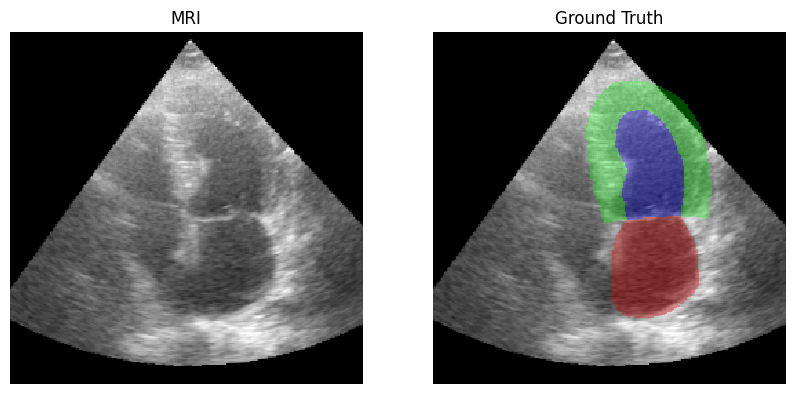

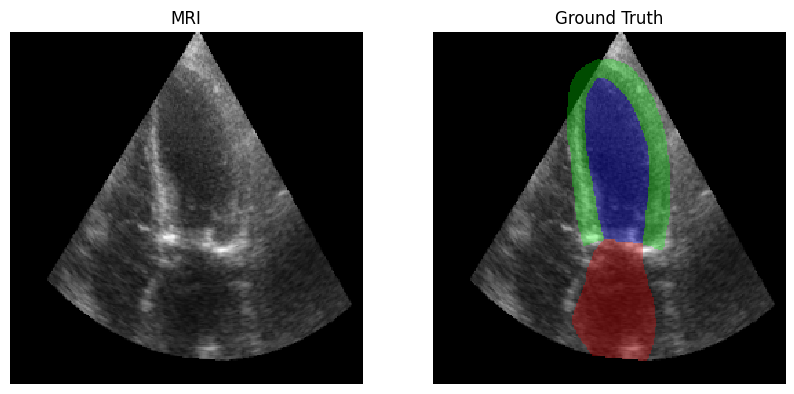

In [10]:
# Compute data augmentation on input images
XX, yy = next(train_gen)

# Display the corresponding transformed images 
plot_overlay_segmentation(XX[0:3,:,:,:], yy[0:3,:,:,:])

***

# <span style="color:brown"> **3) Network and training**
    
## <span style="color:brown"> 3.1) Initialize the network    
    
You are now ready to create a U-Net network from the parameters defined earlier.     
    
    
### <span style="color:red"> Instruction: </span> Run the cell below to create a U-Net model defined through the tensorflow library

In [11]:
from keras_unet.models import custom_unet
from tensorflow.keras import models
from tensorflow.keras import regularizers

# Define the size of the input data
input_shape = (IMG_SIZE, IMG_SIZE, 1)

# This instruction is needed to avoid any confusion with the instantiation of multiple models
if 'model' in locals(): 
    print("deleting existing model")
    del model
    
# Define a U-Net model from the tensorflow library.
model = custom_unet(
    input_shape,
    use_batch_norm=BATCHNORM_ON,  
    num_classes=y_train[0].shape[-1],
    filters=NBFILTERS_L1_UNET, 
    dropout=DROPOUT_RATE,
    num_layers=NBLAYERS_UNET,
    output_activation='softmax',
    kernel_regularizer=None      # You can apply some regularization on the model parameters: .l1(0.001)
    )                            # used kernel_regularizer=0.001 instead of the "None" value

<br>

**Remark**: We coded our own function named `custom_unet` to build the U-Net model from the tensorflow library. For those who are interested in how to define a deep learning model from tensorflow, feel free to analyze the code of this function defined in the file `custom_unet.py` present in the folder named `keras_unet/models`.


### <span style="color:red"> Instruction: </span> Run the cell below and analyze the corresponding architecture.

In [12]:
# display the network architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

### <span style="color:red"> Instruction: </span> Change some parameters of the model (*e.g.* `NBFILTERS_L1_UNET=16` instead of `32`) and re-execute the corresponding cell and the following ones until you reach this cell. 

## <span style="color:brown"> 3.2) Create callbacks for interactions during training

It is possible with tensorflow to define and call some functions (named callback functions) to interact with the learning process. For instance, the callback functions defined above allow the following actions:
- `ModelCheckpoint`: This function indicates to store at the end of the learning process the network parameters that obtained the best score on some metrics passed as input (in our case on the Dice coefficient computed on the validation set) 
- `EarlyStopping`: This function indicates that the learning process should stop if some conditions passed as input are reached (in our case if there is no improvement of the Dice score computed from the validation set after `NBPATIENCE_EPOCHS` epochs)
    

### <span style="color:red"> Instruction: </span> Run the cell below to create the callback functions

In [13]:
import os
os.getcwd()

'c:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main'

In [25]:
model_filename

'trained_model/trained_Unet_f32_b16_l4_do0.1_Std_BN_input.h5'

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


# Create the name for the U-Net model that will be saved
model_path = 'trained_model/'
model_name = 'trained_Unet_f' + str(NBFILTERS_L1_UNET) + '_b' + str(BATCH_SIZE) + '_l'+ str(NBLAYERS_UNET) + '_do' + str(DROPOUT_RATE) +'_Std'
if BATCHNORM_ON == True:
    model_name = model_name + '_BN'
model_filename = model_path + model_name + '_input' + "_epoch_{epoch:02d}" +'.h5'
print(" -> model_study : ", model_name)
print(" -> model_filename : ", model_filename)

# Create first callback function
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1, 
    monitor='val_dice_coef', #'val_loss'
    mode ='max', # use 'min' or 'auto' if val_loss
    save_best_only=True,
)


# Create second callback function
callback_earlystopping = EarlyStopping(
    monitor='val_dice_coef', #'val_loss'
    mode ='max', # use 'min' or 'auto' if val_loss
    patience=NBPATIENCE_EPOCHS,
    restore_best_weights=True  # at the end of fitting, restore best model weights 
)

tensorboard_callback = TensorBoard(log_dir="./logs")



 -> model_study :  trained_Unet_f32_b16_l4_do0.1_Std_BN
 -> model_filename :  trained_model/trained_Unet_f32_b16_l4_do0.1_Std_BN_input_epoch_{epoch:02d}.h5


## <span style="color:brown"> 3.3) Compile the model

In tensorflow, the `compile` function allows the definition of the optimization strategy applied during the learning process of the network model.
    

### <span style="color:red"> Instruction: </span> Run the cell below to define the optimization strategy that will be used during the learning phase

In [29]:
from keras_unet.losses import dice_loss
from keras_unet.metrics import dice_coef
from tensorflow.keras.optimizers import Adam

model.compile(  
    loss=dice_loss,
    optimizer=Adam(learning_rate=0.005),
    metrics=[dice_coef]
)

## <span style="color:brown"> 3.4) It's time to train your first model !

It's now time to start training your first model. By default, the training will be performed on the CPU card of your computer. As you will see, it will take around 10 minutes to perform only 3 epochs. This is the reason why the training of deep learning models is generally performed on GPU cards, which correspond to hardware systems dedicated to intensive computing.  
    

### <span style="color:red"> Instruction: </span> Run the cell below to train your U-Net model. If this step takes too long, you can stop it at any time by clicking the *Interrupt the kernel* button at the top of this page.

In [21]:
import tensorflow as tf

# Check if TensorFlow is using GPU or CPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    mode = 'CPU mode'
else:
    mode = 'GPU mode'

print(mode)

print(tf.config.list_physical_devices('GPU'))

GPU mode
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [31]:
history = model.fit(
    train_gen,
    steps_per_epoch=NBSTEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    epochs=3,
    validation_data=(X_valid, y_valid),
    shuffle=True,
    verbose=1,
    callbacks=[ callback_earlystopping, callback_checkpoint, tensorboard_callback]
)

Epoch 1/3
50/50 [==============================] - ETA: 0s - loss: 0.4075 - dice_coef: 0.8640
Epoch 1: val_dice_coef did not improve from 0.91385
50/50 [==============================] - 17s 342ms/step - loss: 0.4075 - dice_coef: 0.8640 - val_loss: 0.3966 - val_dice_coef: 0.9129
Epoch 2/3
50/50 [==============================] - ETA: 0s - loss: 0.4102 - dice_coef: 0.8612
Epoch 2: val_dice_coef did not improve from 0.91385
50/50 [==============================] - 21s 425ms/step - loss: 0.4102 - dice_coef: 0.8612 - val_loss: 0.4002 - val_dice_coef: 0.9125
Epoch 3/3
50/50 [==============================] - ETA: 0s - loss: 0.4085 - dice_coef: 0.8726
Epoch 3: val_dice_coef improved from 0.91385 to 0.91400, saving model to trained_model\trained_Unet_f32_b16_l4_do0.1_Std_BN_input_epoch_03.h5
50/50 [==============================] - 23s 454ms/step - loss: 0.4085 - dice_coef: 0.8726 - val_loss: 0.3975 - val_dice_coef: 0.9140


## <span style="color:brown"> 3.5) Plot training and validation history
    
After the learning of a network, it is interesting to analyse the behavior of the training and validation loss curves to see if the training went well (*i.e.* decrease of the curves since the goal of the training is to minimize the loss function across the epochs).  

### <span style="color:red"> Instruction: </span> Run the cell below to display the loss and metric curves corresponding to the learning process you just executed.    

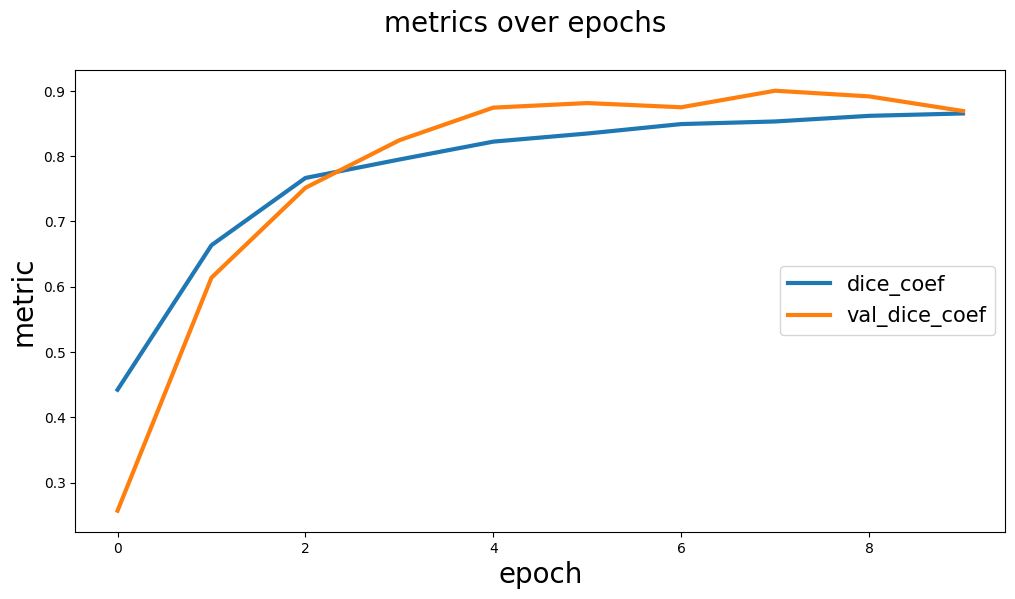

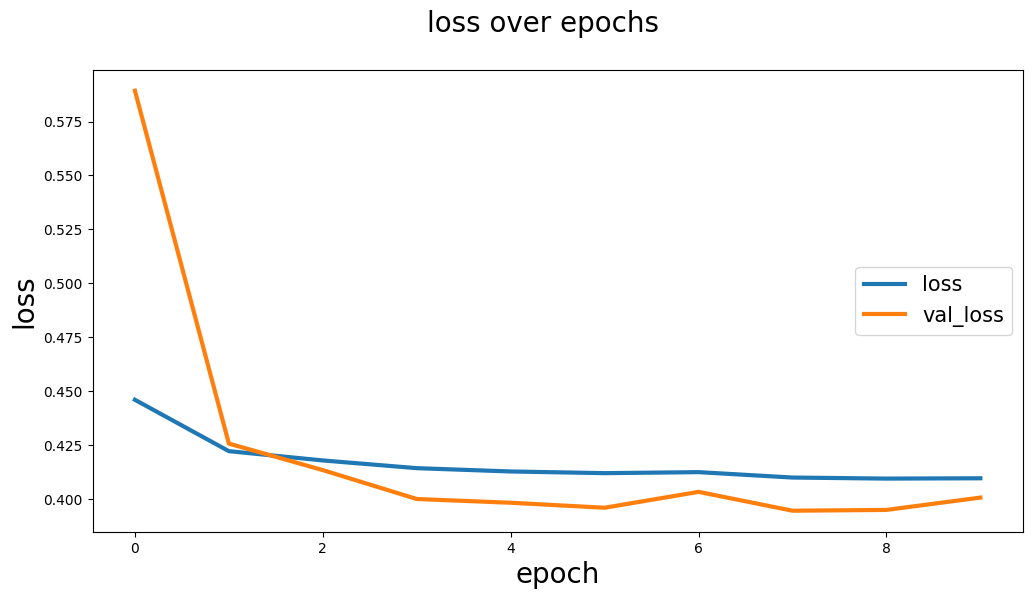

In [23]:
from keras_unet.visualization import plot_segm_history

plot_segm_history(history,  metrics=['dice_coef', 'val_dice_coef'])

### <span style="color:red"> Questions: </span>

- ### What information can you retrieve from these curves ? 
- ### Why is it important to use a validation set ? 
- ### Why don't we use directly the testing dataset instead ?

>TODO: Your answer here.

## <span style="color:brown"> 3.6) Select which model to play with

As you can see, the number of epochs is not sufficient to achieve convergence. This means that the model was still learning at the end of the training process. Since you are working on the CPU card of your computer by default, restarting a training with more epochs would take too much time. So we have run 8 different trainings for you. For each of these training runs we learned a model over 400 epochs and saved the best learned parameters and the associated loss and metric curves. We have used an early stopping callback function, so some training ended before the 100 epochs. ***The corresponding data were stored on a remote server. To be able to use these models, you have to first download the archive [(download link)](https://www.creatis.insa-lyon.fr/~bernard/handsonsegmentation) and extract it at the root of this notebook.*** You will afterwards be able to load each of these models and analyze their performance. This will allow you to analyze the influence of the main parameters to be defined when learning a U-Net model. The different models that have been learned are the following:
- ***model_1***: This is the reference model that you have used during the first hands on session. The default settings provided in the cell in section 3-1 were used.
- ***model_2***: This model uses the same parameters as *model_1* except the number of feature maps at the first level. This parameter was set to: *NBFILTERS_L1_UNET = 16*.
- ***model_3***: This model uses the same parameters as *model_1* except the number of level. This parameter was set to: *NBLAYERS_UNET = 3*.
- ***model_4***: This model uses the same parameters as *model_1* except the number of level. This parameter was set to: *NBLAYERS_UNET = 5*.
- ***model_5***: This model uses the same parameters as *model_1* except that there was no dropout (DROPOUT_RATE=0.0).
- ***model_6***: This model uses the same parameters as *model_1* except that there was no data augmentation.
- ***model_7***: This model uses the same parameters as *model_1* except that the learning rate used during the optimisation process was set to *0.1* instead of *0.001*.
- ***model_8***: This model uses the same parameters as *model_1* except that the network optimization was performed using the RMSprop algorithm instead of the classical ADAM's algorithm.  


### <span style="color:red"> Instruction: </span> Run the cell below to select which model you want ot work with.

## Load a trained model

In [5]:
from tensorflow.keras import models
from keras_unet.losses import dice_loss
from keras_unet.metrics import dice_coef

model_path = './trained_model/trained_Unet_f32_b16_l4_do0.1_Std_BN_input_epoch_03.h5'
model = models.load_model(model_path, 
              custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})    

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## <span style="color:brown"> 3.7) Visual assessment of the quality of the predictions
    
### <span style="color:red"> Instruction: </span> Run the cell below to apply the U-Net model on the full test dataset, predict the different segmentation masks and compute the metrics defined above.

100/100 [==============================] - 5s 8ms/step


100%|██████████| 100/100 [00:03<00:00, 26.08it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.87,34.21,4.35
Right Ventricle,0.85,23.54,4.99
Myocardium,0.85,28.86,3.73
Left Ventricle,0.91,24.65,4.33


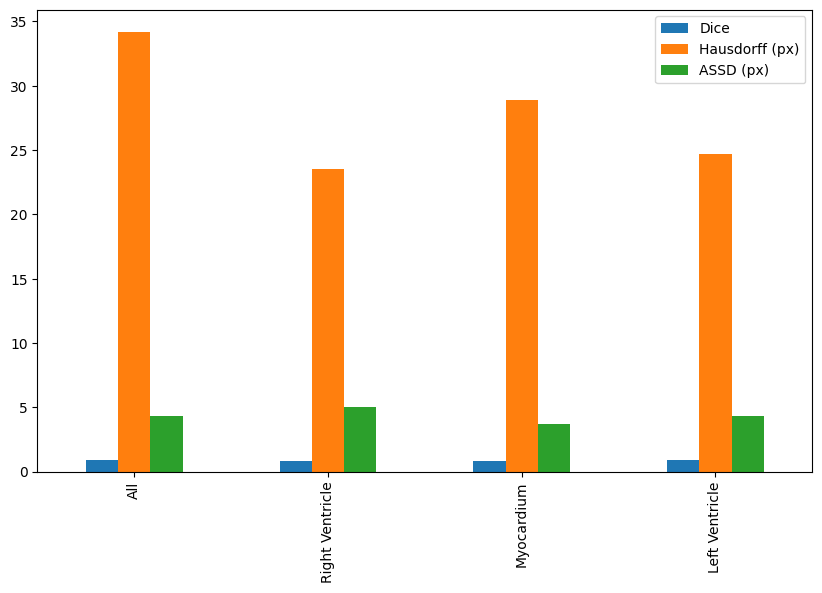

In [6]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set
import pandas as pd
from IPython.display import display, HTML 

# Predict segmentations on the full test dataset
y_pred = model.predict(X_test, batch_size=1, verbose=1)

# Compute score on the full test dataset
dice_all, hausdorff_all, assd_all, valid_all = evaluate_set(y_test, y_pred)

# Put the results into a matrix and graft it into a pandas data frame (object from the panda library)
overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
overall_results_df = pd.DataFrame(data=overall_results, index = ["All", "Right Ventricle", "Myocardium", "Left Ventricle"], 
                                  columns=["Dice", "Hausdorff (px)", "ASSD (px)"]) 

# Display the data as HTML tables and graphs
display(HTML(overall_results_df.to_html(float_format=lambda x: '%.2f' % x)))
overall_results_df.plot(kind='bar', figsize=(10,6)).legend() #bbox_to_anchor=(1.6,0.9))

In [7]:
overall_results_df.to_csv('./result/overall_results_df.csv', index=True)

### <span style="color:red"> Instruction: </span> Run the cell below to display some prediction results. Don't hesitate to re-run the cell several times to see more cases.

In [39]:
import medpy
medpy.__version__

'0.3.0'

In [ ]:
from keras_unet.visualization import plot_compare_segmentation

# Select random values
nb_imgs = 3
start_ind = (np.random.randint(0, X_test.shape[0]-nb_imgs, size=1))[0]
end_ind = start_ind+nb_imgs

# Display the random images with the corresponding reference and predicted mask
plot_compare_segmentation(X_test[start_ind:end_ind], y_test[start_ind:end_ind], y_pred[start_ind:end_ind], " ", spacing=(1,1), step=1)

### <span style="color:red"> Questions

- ### Compare the performance of the different models
- ### Are the results relatively stable with respect to parameter changes ?
- ### Which parameter changes have particularly degraded the results ?

>TODO: Your answer here.